In [1]:
from glob import glob
import json
import os
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

#### Plot electrodes

### Load experiment

In [6]:
recfolder = r"E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_estim_2022-12-20_12-26-39\experiment1\recording1"
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [7]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load EEG data

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [9]:
print(eeg_ts[0])
print(eeg_ts[-1])

52.67653295206478
4437.547815569076


In [10]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

### Load LC auto-detected SWDs

In [11]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is


In [12]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,62.907683,65.411671,2.503988,19,"[62.90768339318237, 63.042882738287446, 63.158..."
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
2,73.099234,74.083229,0.983995,9,"[73.09923402611828, 73.21323347391399, 73.3440..."
3,78.675207,81.261194,2.585987,17,"[78.67520701654675, 78.80320639652788, 78.9444..."
4,83.168785,84.357979,1.189194,10,"[83.16878525000968, 83.2935846454913, 83.42478..."


Print some stats

In [13]:
print('Number of SWDs in {:d} min recording: {:d} events'.format(int((eeg_ts[-1]-eeg_ts[0])/60), len(autoSWD_df)))
print('Average SWD duration: {:.1f} s [min={:.1f}, max={:.1f}]'.format(
    np.mean(autoSWD_df['duration'].values), np.min(autoSWD_df['duration'].values), np.max(autoSWD_df['duration'].values)))
print('Total time spent in SWD: {:.1f} min'.format(np.sum(autoSWD_df['duration'].values)/60))

Number of SWDs in 73 min recording: 829 events
Average SWD duration: 2.8 s [min=0.5, max=11.5]
Total time spent in SWD: 39.3 min


### Load the stim log

In [14]:
if os.path.exists(exp.stimulus_log_file):
    stim_log = pd.read_csv(exp.stimulus_log_file)
else:
    print('No stim log for this experiment')

In [15]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good
0,biphasic,50,0.0004,3004.42943,3004.42983,0,10.281199,False,True,True
1,biphasic,50,0.0004,3025.43502,3025.43542,0,5.057074,False,True,True
2,biphasic,50,0.0004,3044.45591,3044.45631,0,0.000000,True,True,True
3,biphasic,50,0.0004,3064.48025,3064.48065,0,0.432813,False,True,True
4,biphasic,50,0.0004,3085.27708,3085.27748,0,4.700194,False,False,True


### Plot whole recording with SWD annotated events

Text(0.5, 1.0, 'Mouse 645606: EEGNPXspont_estim')

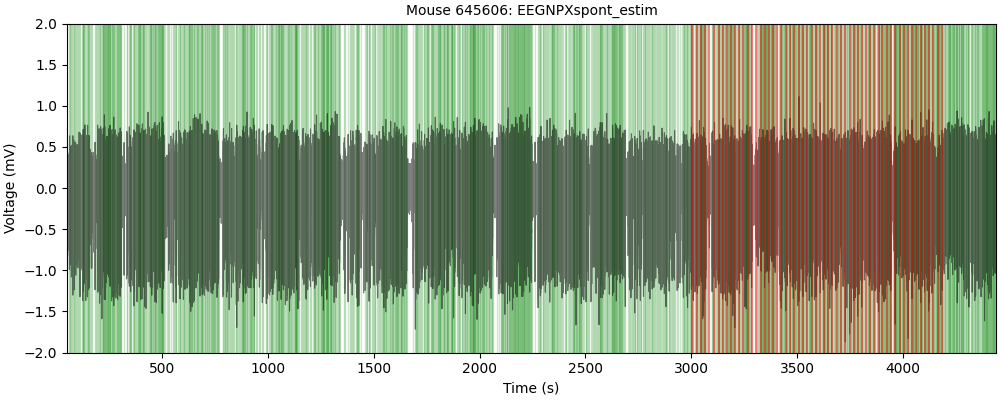

In [16]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)

ax.plot(eeg_ts, filt_data[:,18], color='k', linewidth=0.8, alpha=0.5)
for ii, Lrow in autoSWD_df.iterrows():
    ax.axvspan(Lrow.onset, Lrow.offset, color='g', alpha=0.2)

for jj, stimrow in stim_log.iterrows():
    ax.axvline(stimrow.onset, color='r', alpha=0.5)
    
ax.set_xlim([eeg_ts[0], eeg_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylim([-2.0, 2.0])
ax.set_ylabel('Voltage (mV)')
ax.set_title('Mouse {}: {}'.format(exp.mouse, exp_tag))

## Plot some example windows with the units to examine event onsets

### Load units and spikes

In [46]:
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,other-TH
1,B4,probeB,1,3640,0.508208,AMv,253,179,195,other-TH
2,B9,probeB,3,3620,0.590620,AMv,253,178,195,other-TH
3,B10,probeB,4,3600,0.480737,AMv,253,177,194,other-TH
4,B11,probeB,5,3600,0.480737,AMv,253,177,194,other-TH


In [47]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

HIP: 113 units
MO: 73 units
PAL: 69 units
RT-TH: 12 units
SM-TH: 59 units
SS: 135 units
STR: 97 units
VIS: 24 units
other-TH: 208 units


In [18]:
print(np.unique(unit_info['region'].values))

['AMd' 'AMv' 'AV' 'BST' 'CA1' 'CA2' 'CA3' 'CP' 'DG-po' 'DG-sg' 'LD'
 'LGd-co' 'LGd-sh' 'MGd' 'MGm' 'MGv' 'MOp2/3' 'MOp5' 'MOp6a' 'RT'
 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a' 'SSp-bfd6b' 'SSp-ll6a'
 'SSp-tr4' 'SSp-tr5' 'SSp-tr6a' 'STR' 'TH' 'VAL' 'VISp5' 'VISp6a' 'VISp6b'
 'VL' 'VPL' 'ZI' 'bsc' 'ccb' 'cing' 'em' 'fp' 'or']


First-order TH: VL, dLGN, MG
<br> Higher-order TH: VA, MD, CL, Pulv

## Plot a window with EEG and unit rasters

In [48]:
print(eeg_ts[0])
print(eeg_ts[-1])

79.3536544827942
6682.103505585035


In [49]:
print(stim_log.onset.values[0])

1803.26003


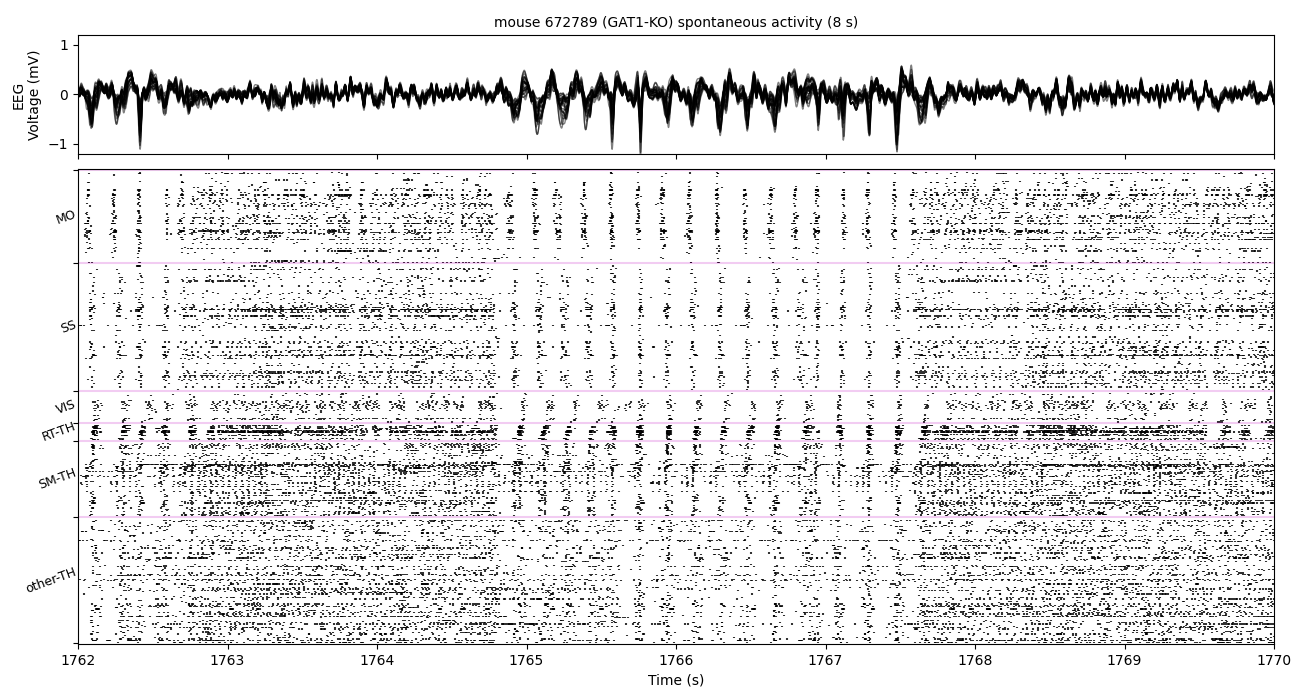

In [51]:
window = [1762, 1762+8]
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'VIS', 'SS', 'MO']
umax = 100

fig = plt.figure(figsize=(13, 7)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.08, hspace=0.05, height_ratios=[1,4])
EEGax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > window[0]) & (eeg_ts < window[1]))[0]
# EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(window)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1.2, 1.2])
# EEGax.set_ylim([-0.25, 0.25])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('mouse {} (GAT1-KO) spontaneous activity ({:d} s)'.format(exp.mouse, int(np.diff(window))))
# EEGax.set_title('Wild type (not litter mate): spontaneous activity')

## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > window[0]) & (uspiketimes < window[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(window[0], last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(window)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = 'spont_EEG_NPX_{:d}-{:d}s.png'.format(int(window[0]), int(window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Plot an SWD event

In [19]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'VIS', 'SS', 'MO']

In [36]:
SWDind = 17
SWDevent = autoSWD_df.iloc[SWDind]
print(SWDevent.duration)

0.5935977611901535


In [29]:
deltat = 5.0 # time around SWD to plot, s

Plot EEG + all region raster

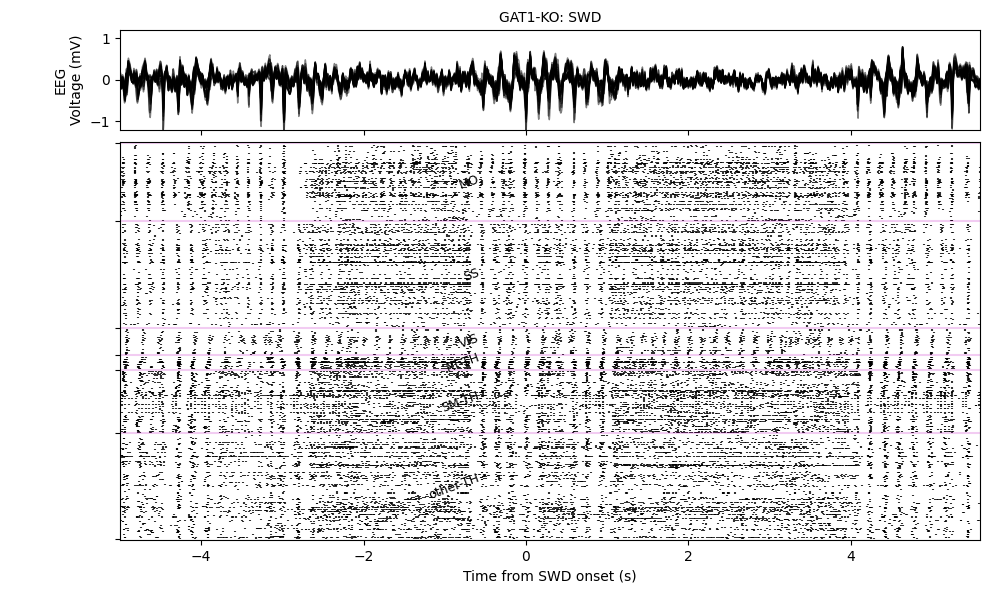

In [37]:
## Plot one half-slide ##
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
# timezero = 100.0
# pwin = np.array([100.0 - deltat, 102.1 + deltat])
umax = 100

fig = plt.figure(figsize=(10, 6)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.12, right=0.98, top=0.95, bottom=0.1, hspace=0.05, height_ratios=[1,4])
EEGax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > pwin[0]) & (eeg_ts < pwin[1]))[0]
# EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(pwin - timezero)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1.2, 1.2])
# EEGax.set_ylim([-0.25, 0.25])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('GAT1-KO: SWD')
# EEGax.set_title('Wild type (not litter mate): spontaneous activity')

## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwin[0]) & (uspiketimes < pwin[1]))[0]
        ]
        rasterax.eventplot(SWDspikes - timezero, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(-0.55, last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwin - timezero)
rasterax.set_xlabel('Time from SWD onset (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = 'SWD_EEG_NPX_example{:d}.png'.format(SWDind)
# fig_name = 'spont_EEG_NPX_example.png'
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Plot ALL region raster

### Plot multiple SWD events

In [22]:
len(autoSWD_df)

829

In [25]:
autoSWD_df[(autoSWD_df['duration'] > 1.8) & (autoSWD_df['duration'] < 2.2)][:10]

,onset,offset,duration,spike_count,SWD_spike_times
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
21,196.202070,198.354060,2.151990,13,"[196.20206980036556, 196.33886915980443, 196.4..."
34,251.572628,253.498624,1.925996,14,"[251.57262780484655, 251.9530270677896, 252.10..."
35,254.475422,256.303019,1.827596,13,"[254.4754221804278, 254.61662190684095, 254.75..."
45,300.105219,302.073239,1.968020,13,"[300.1052188619777, 300.2220200312601, 300.348..."
47,306.862087,308.998882,2.136796,13,"[306.86208650416586, 307.0236881219402, 307.20..."
105,635.813841,637.819856,2.006015,14,"[635.8138406935439, 635.9538417334074, 636.243..."
130,745.071978,747.047959,1.975981,14,"[745.0719779810114, 745.2023767176904, 745.333..."
133,754.566686,756.618666,2.051980,13,"[754.5666859949622, 754.6914847858942, 754.993..."
134,758.479048,760.335030,1.855982,15,"[758.4790480914552, 758.5934469831428, 758.733..."


In [28]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'SS']
deltat = 0.5 # time around SWD to plot, s
SWDinds = [1, 34, 35, 45, 47]

<IPython.core.display.Javascript object>


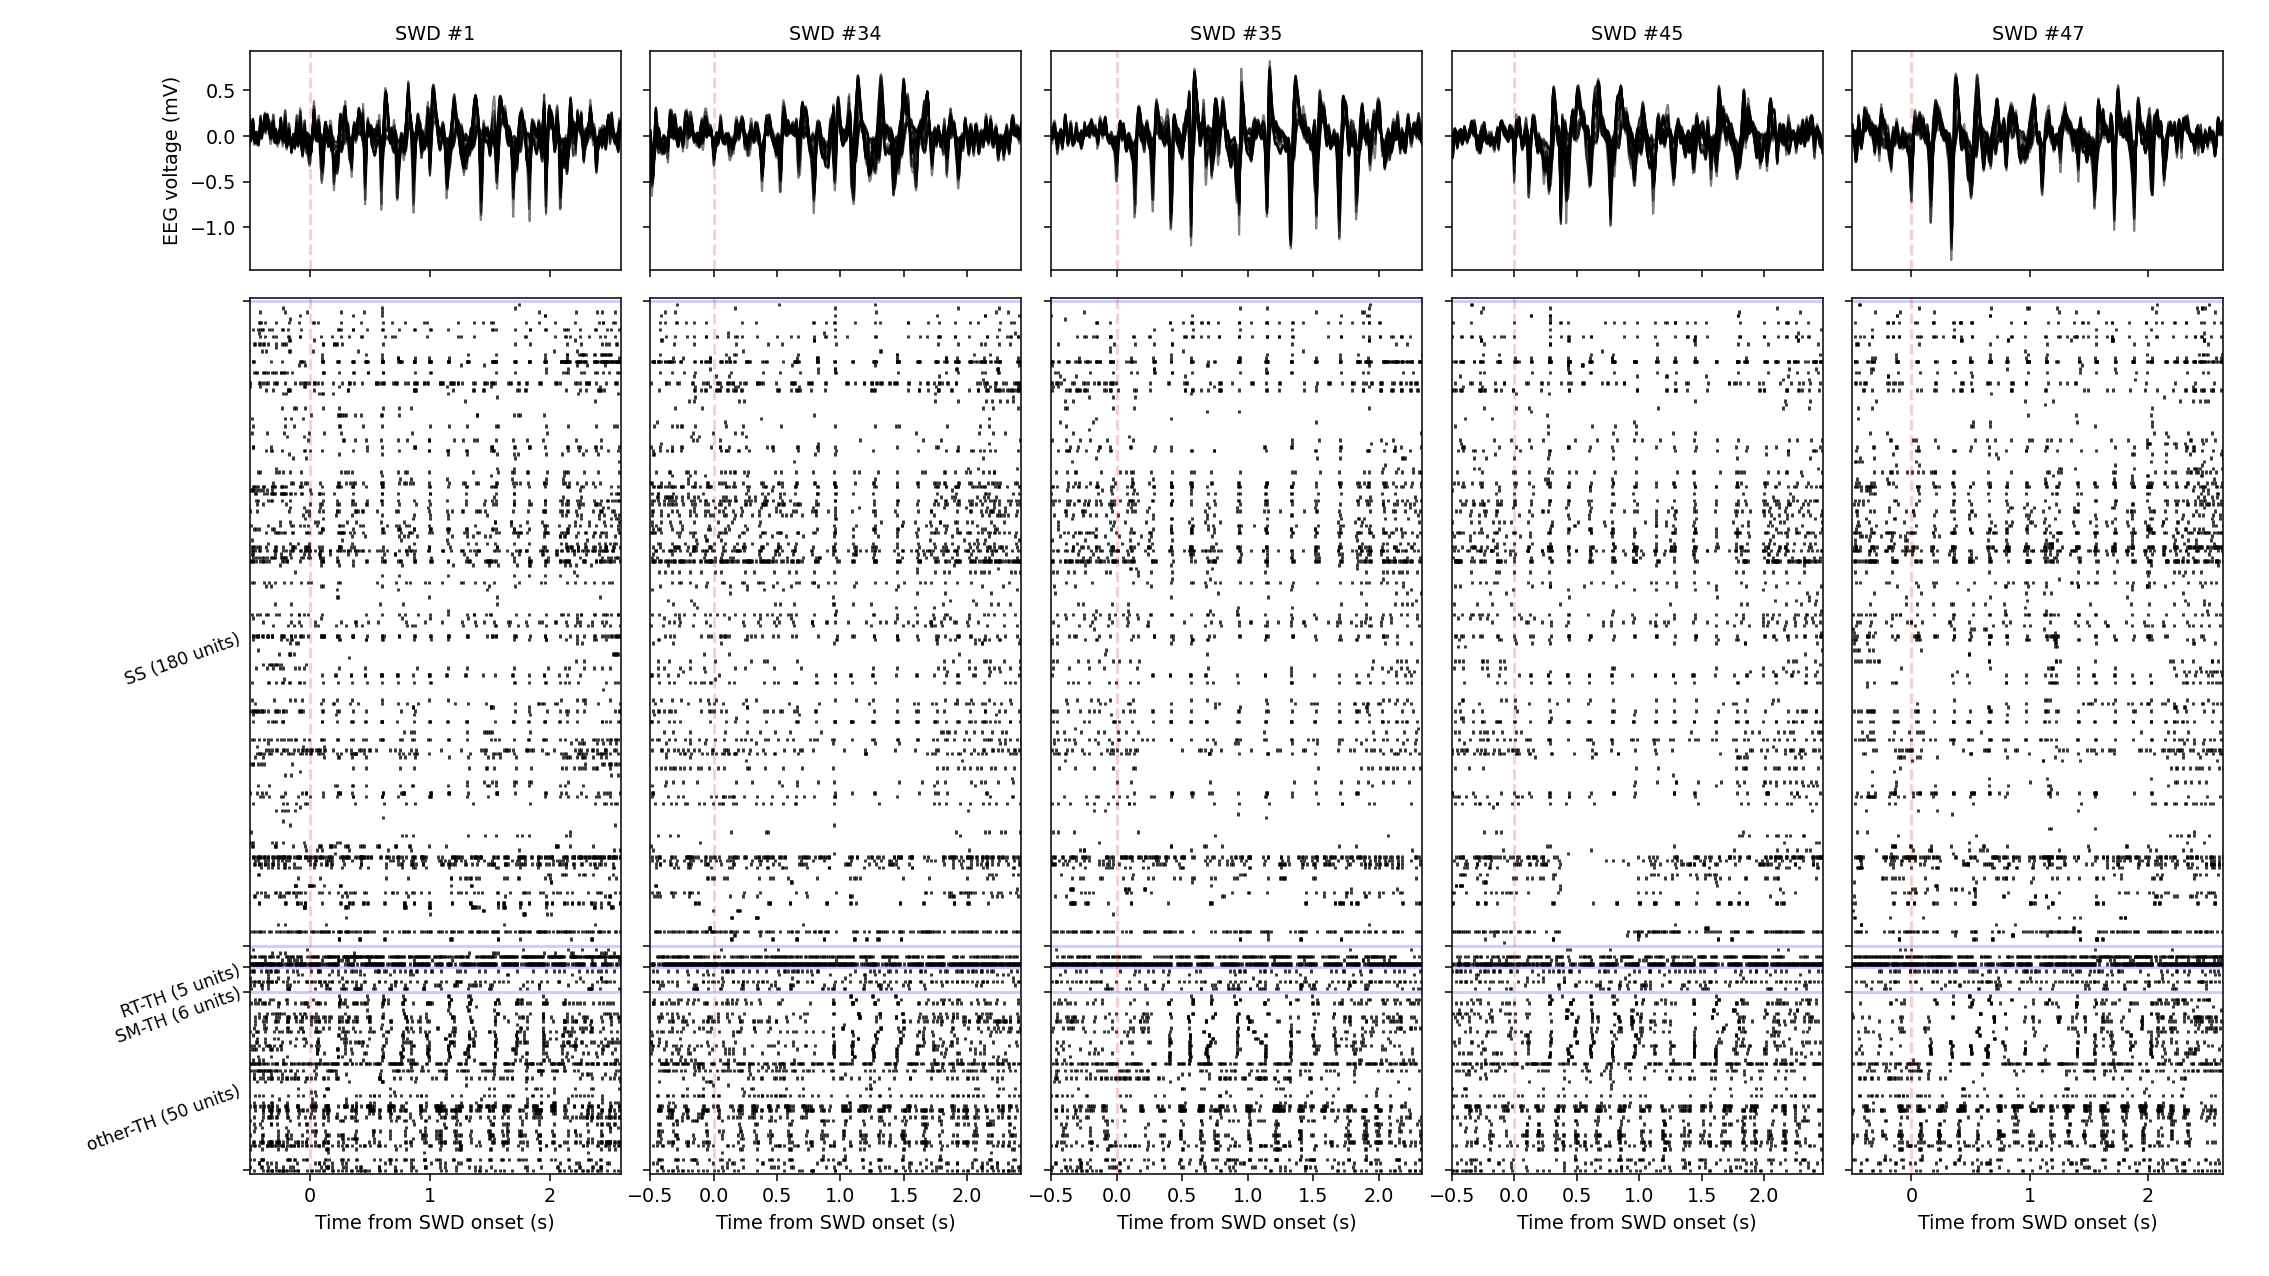

In [29]:
fig = plt.figure(figsize=(12, 6.75)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.11, right=0.98, top=0.96, bottom=0.08, hspace=0.05, height_ratios=[1,4])
EEGaxs = gs[0].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)
rasteraxs = gs[1].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)

for coli, SWDind in enumerate(SWDinds):
    SWDevent = autoSWD_df.iloc[SWDind]
    timezero = SWDevent.onset
    plotwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
    
    ## Plot EEG ##
    eeginds = np.nonzero((eeg_ts > plotwin[0]) & (eeg_ts < plotwin[1]))[0]
    EEGaxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    EEGaxs[coli].plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
    EEGaxs[coli].set_xlim(plotwin - timezero)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_title('SWD #{:d}'.format(SWDind))
    
    ## Plot raster ##
    rasteraxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    last_ind = 0
    regb = [last_ind]
    for ii, pregi in enumerate(plot_regions):
        regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
        for indi, urow in regdf.iterrows():
            uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
            SWDspikes = uspiketimes[
                np.nonzero((uspiketimes > plotwin[0]) & (uspiketimes < plotwin[1]))[0]
            ]
            rasteraxs[coli].eventplot(SWDspikes - timezero, lineoffsets=indi + last_ind, linelengths=1.0, color='black', alpha=0.8)
        if coli == 0:
            rasteraxs[coli].annotate(
                '{} ({:d} units)'.format(pregi, len(regdf)), xy=(-0.55, last_ind + indi/2 - 10), xycoords='data',
                annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
            )
        last_ind += indi + 2
        regb.append(last_ind - 1)
        rasteraxs[coli].axhline(last_ind - 1, color='b', alpha=0.2)

    rasteraxs[coli].set_ylim(-1, last_ind)
    rasteraxs[coli].set_xlim(plotwin - timezero)
    rasteraxs[coli].set_xlabel('Time from SWD onset (s)')
    rasteraxs[coli].set_yticks(regb)
    rasteraxs[coli].set_yticklabels([])

EEGaxs[0].set_ylabel('EEG voltage (mV)')

### SAVE ###
fig_name = 'multiSWD_EEG_NPX_example.png'
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)